## Comparing the SNR in the 0.8nm and 3nm data

Data was taken on 2021-10-09 (3nm) and 2021-11-28 (0.8nm) with Dragonfly301.

The moon was at slightly different locations on those nights, which may produce a difference. In addition, we don't have flats taken close by, so there are going to be some errors.

Steps:
1. Dark subtract with master dark from May 2021 (best we can do...)
2. Flat field with flat from May 2021 (once again best we can do... can also try and compare using a flat taken in the summer 2022 with the 0.8nm filters)
3. Sky noise calculation - robust sigma (biweight? or 1.46*NMAD = normalized median absolute deviation)


The MAD is defined as the median of the absolute deviations from the data's median 
$\tilde {X}=\operatorname {median} (X)$: 

$$\mathrm{MAD} = \mathrm{median} (|X_{i}-{\tilde {X}}|)$$

The MAD may be used similarly to how one would use the deviation for the average. In order to use the MAD as a consistent estimator for the estimation of the standard deviation $\sigma$, one takes

$$\hat\sigma=k\cdot \mathrm{MAD} $$

where $k$ is a constant scale factor, which depends on the distribution. For normally distributed data $k$ is taken to be 1.4826.

In [2]:
from statsmodels import robust
import numpy as np

#define data
data = np.array([1, 4, 4, 7, 12, 13, 16, 19, 22, 24])

#calculate MAD
robust.mad(data,c=1)*1.48


11.1

In [3]:
import os
from glob import glob
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Longitude, Latitude, match_coordinates_sky, SkyCoord
from astropy.utils.data import get_pkg_data_filename

from photutils import SkyCircularAperture
from photutils import aperture_photometry

from dfreduce import utils
from dfreduce import astrometry
from dfreduce.viz import show_image
from dfreduce.detection import sextractor

%matplotlib inline

/var/folders/cx/tgcvyx4j0dv34dk3cw2x965w0000gp/T/ipykernel_70976/2194545909.py:13: DeprecationWarning: `photutils.SkyCircularAperture` is a deprecated alias for `photutils.aperture.SkyCircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import SkyCircularAperture` to silence this warning.
  from photutils import SkyCircularAperture
/var/folders/cx/tgcvyx4j0dv34dk3cw2x965w0000gp/T/ipykernel_70976/2194545909.py:14: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry
WARNING [__init__.py:17] Default raw data path environment variable not defined
WARNING [__init__.py:19] Default database path environment variable not defined
WARNING [__init__.py:21] Default MasterCals path environment variable not defined


### Image paths

In [5]:
# basedir = '/Users/lokhorstd/Dropbox/Dragonfly/MassiveNarrowbandUpgrade/FilterComparison3nm0.8nm'
basedir = '/Users/lokhorstd/Documents/Dragonfly/MassiveNarrowbandUpgrade/FilterComparison3nm0.8nm/'

image_08nm = os.path.join(basedir,'2021-11-28','DRAGONFLY301_4_light_8A_WCS.fits')
image_3nm = os.path.join(basedir,'2021-10-09','DRAGONFLY301_14_light_30A_WCS.fits')

# select the nearest dark with exptime:
print(fits.getheader(image_3nm)['EXPTIME'])
print(fits.getheader(image_08nm)['EXPTIME'])

# select the nearest flat with tilt:
print(fits.getheader(image_3nm)['CORRTILT'])
print(fits.getheader(image_08nm)['CORRTILT'])

1800.0
1800.0
12.63
18.78


### Dark and Flat paths

In [6]:
# darkdir = '/Users/lokhorstd/Dropbox/Data/dragonfly/Masters/master_darks/2021-05-11'
# flatdir = '/Users/lokhorstd/Dropbox/Data/dragonfly/Masters/master_flats/2021-05-11'
darkdir = '/Users/lokhorstd/Library/CloudStorage/Dropbox/Data/dragonfly/Masters/master_darks/2021-05-11'
flatdir = '/Users/lokhorstd/Library/CloudStorage/Dropbox/Data/dragonfly/Masters/master_flats/2021-05-11'

darkfn = os.path.join(darkdir,'master_DRAGONFLY301_dark_1800.0.fits')
flatfn = os.path.join(flatdir,'master_DRAGONFLY301_flat_12.5.fits')

(<Figure size 1300x1300 with 2 Axes>, <Axes: >)

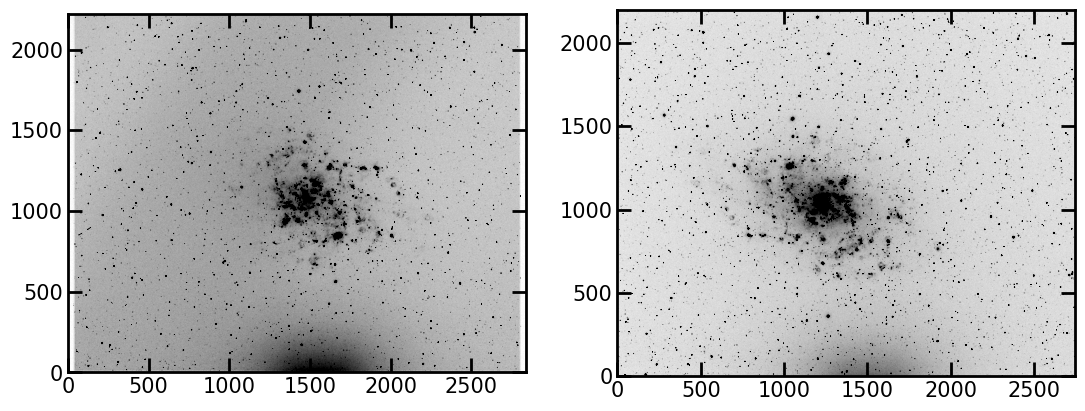

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,13))

show_image(image_08nm,subplots=(fig,ax1))
show_image(image_3nm,subplots=(fig,ax2))

### Open files, dark subtract and flat field

(<Figure size 1300x1300 with 2 Axes>, <Axes: >)

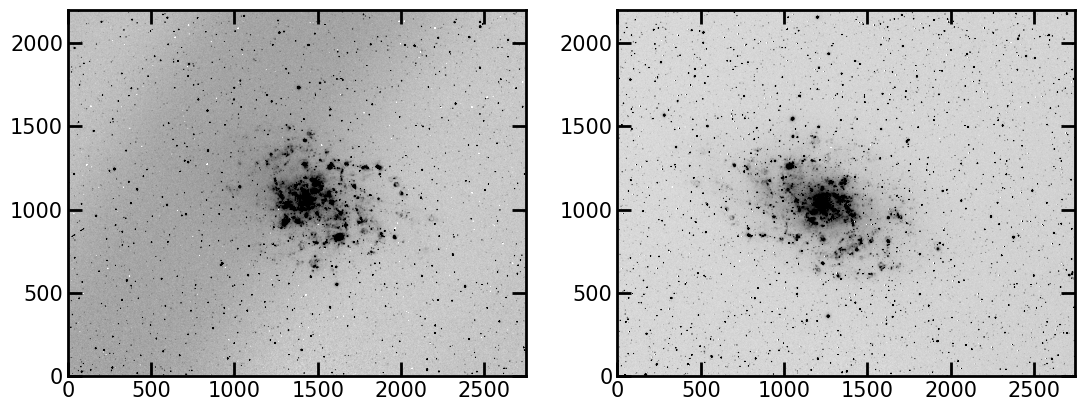

In [8]:
im08nm = utils.load_path_or_pixels(image_08nm, bounds=(12,2212,45,2795))
im3nm = utils.load_path_or_pixels(image_3nm, bounds=(12,2212,45,2795))
imdark = fits.getdata(darkfn)
imflat = fits.getdata(flatfn)

# dark subtract
im08nm_ds = im08nm - imdark
im3nm_ds = im3nm - imdark

# flat field
im08nm_ds_ff = im08nm_ds / imflat
im3nm_ds_ff = im3nm_ds / imflat

# continuum subtract?

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,13))
show_image(im08nm_ds_ff,subplots=(fig,ax1))
show_image(im3nm_ds_ff,subplots=(fig,ax2))

In [8]:
image_08nm.replace('.fits','_ds_ff.fits')

'/Users/lokhorstd/Dropbox/Dragonfly/MassiveNarrowbandUpgrade/FilterComparison3nm0.8nm/2021-11-28/DRAGONFLY301_4_light_8A_WCS_ds_ff.fits'

In [9]:
head08nm = utils.load_path_or_header(image_08nm)
head3nm = utils.load_path_or_header(image_3nm)

utils.write_pixels(image_08nm.replace('.fits','_ds_ff.fits'), im08nm_ds_ff, header=head08nm)
utils.write_pixels(image_3nm.replace('.fits','_ds_ff.fits'), im3nm_ds_ff, header=head3nm)

### open the headers and run source-extractor to grab out the fluxes (signal)

In [9]:
head08nm = utils.load_path_or_header(image_08nm)
head3nm = utils.load_path_or_header(image_3nm)

In [10]:
cat08nm = sextractor.run(im08nm_ds_ff,
                         header=head08nm,
                         DETECT_THRESH=10.0, 
                         extra_params='X_WORLD,Y_WORLD,FLUXERR_AUTO')

cat3nm = sextractor.run(im3nm_ds_ff,
                        header=head3nm,
                        DETECT_THRESH=10.0, 
                        extra_params='X_WORLD,Y_WORLD,FLUXERR_AUTO')


In [11]:
cat08nm.sort(['FLUX_RADIUS'])
cat08nm

<Table length=983>
 X_IMAGE   Y_IMAGE  FLUX_AUTO ...   X_WORLD      Y_WORLD    FLUXERR_AUTO
   pix       pix        ct    ...     deg          deg           ct     
 float64   float64   float64  ...   float64      float64      float64   
--------- --------- --------- ... ------------ ------------ ------------
 777.8859  2147.925  64483.29 ... 22.632212382 30.188697579     438.9934
   5.0713 1123.0663   4336.59 ... 23.419785052  29.67501508      158.723
1599.0077 2026.9973  4964.663 ... 22.723274902 30.735821025     168.2517
 448.9956  313.0072  4614.653 ... 24.043282525 29.967951334     165.4167
 939.0142 2006.0081   5039.98 ... 22.741116991 30.296392035     168.8556
1431.0077  841.9969  14311.63 ... 23.640480532 30.623927144     231.4535
2004.0055 1230.9935  7502.696 ... 23.340509639 31.006222017     187.5319
1531.0021  907.9919  10663.65 ... 23.589765953 30.690687602     209.0725
2028.9977 1322.0016  20426.54 ... 23.269850621 31.022931615     264.7593
      ...       ...       ... ...          ...          ...          ...
1293.2603   907.568  176850.3 ... 23.589276418 30.532365332      1162.26
 1489.428 1115.7961  207267.1 ... 23.428783921 30.663408313     1247.572
 1434.157  970.9766  203652.3 ... 23.540701769 30.626338824     1458.561
1443.5873 1072.2375  340084.7 ... 23.462380432 30.632812242     1430.588
 1335.501 1019.3019  261783.2 ... 23.503032015 30.560737996     1321.484
1419.0027 1098.6853  227722.8 ... 23.441856892 30.616483164     1260.568
1432.3207 1052.3596  561218.9 ... 23.477730941 30.625275109     1812.917
1426.9692 1101.2379  452299.2 ... 23.439901319 30.621792368     1760.701
1314.1241  933.7288  334668.9 ...  23.56912427 30.546321409     1620.322
1446.7007 1060.4659  824933.6 ... 23.471496926 30.634865536     2513.441

In [12]:
cat3nm.sort(['FLUX_RADIUS'])
cat3nm

<Table length=2214>
 X_IMAGE   Y_IMAGE  FLUX_AUTO ...   X_WORLD      Y_WORLD    FLUXERR_AUTO
   pix       pix        ct    ...     deg          deg           ct     
 float64   float64   float64  ...   float64      float64      float64   
--------- --------- --------- ... ------------ ------------ ------------
2518.5461 1672.0009   -3515.5 ...  23.96535462 29.801494615     143.3726
1429.5798   486.972 -18008.85 ... 23.044843211 30.518553627     143.3726
 2732.584  1762.998 -3911.068 ... 24.036036767 29.659370395     134.1128
1612.5023 1830.0002 -348.4566 ... 24.082911526 30.405155448     143.3726
 416.4998  559.0001 -302.5907 ... 23.089624361 31.193445804     143.3726
2251.5017  173.0005 -862.0894 ... 22.812702485 29.968344884     143.3726
  967.504  403.0033 -743.1554 ... 22.974682668 30.825301894     143.3726
2206.5076 1703.9996 -2011.049 ... 23.988456743 30.009322679     143.3726
2020.5084  571.0026 -2194.012 ... 23.115967844 30.125975278     143.3726
      ...       ...       ... ...          ...          ...          ...
1408.5316   974.043  601952.8 ...  23.42086935    30.536545     2265.881
1293.3103 1000.0037  761215.8 ...  23.43996352 30.613421082     2430.572
1219.8817 1017.9301 1002574.0 ...  23.45321663 30.662420008     2959.856
1364.4889 1052.9341  718290.9 ... 23.481459101 30.566404342     2448.136
1388.1105 1009.7346 1116180.0 ... 23.448272543 30.550387214     3012.983
1353.2596 1075.9447 1326568.0 ... 23.499151374 30.574031893     3520.067
1246.9119 1010.7892 1322245.0 ... 23.447917346 30.644379342     3483.361
1189.9357 1032.5175 1252845.0 ... 23.464254932 30.682451998     3434.332
1234.5427 1039.0212 3592192.0 ... 23.469650247 30.652805367     5233.706
1238.8953  988.6181 2841550.0 ...  23.43070362 30.649561106      5355.14

In [33]:
# run source extractor again and make a mask so I can select out the HII regions 
# and make sure they are being covered correctly? --> grab it from my u toronto laptop


In [79]:
# def find_nearest_idx(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

# # find index of the cats eye nebula by the ra and dec location
# # ind = find_nearest_idx(cat3nm['Y_WORLD'],30.945)

# show_image(im3nm_ds_ff)
# for ii in range(10):
#     plt.plot(cat3nm['X_IMAGE'][-1*ii],cat3nm['Y_IMAGE'][-1*ii],'ro',ms=15,alpha=0.5)


158.3615264892578 595.0914459228512
3nm data: The total flux of sky in the patch is: 86032.42
3nm data: The mean sky flux in the patch is: 190.76
3nm data: The NMAD approx of sky in the patch is: 33.48


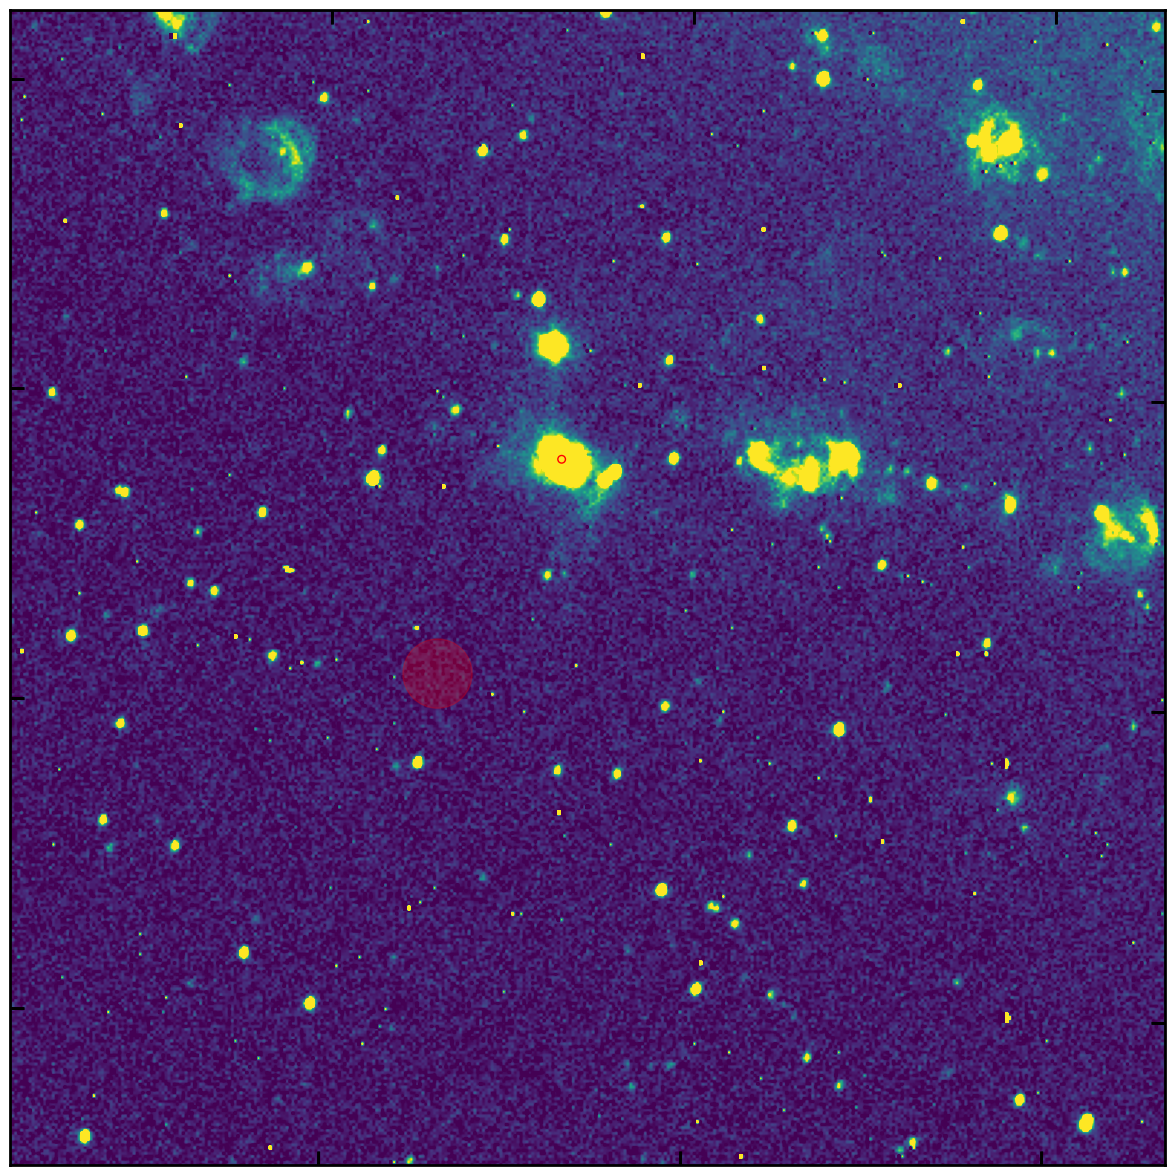

In [18]:
plt.figure(figsize=(15,15))
ax = plt.subplot(projection=WCS(head3nm))#, label='overlays')

percentile=[20, 99]
vmin, vmax = np.nanpercentile(im3nm_ds_ff, percentile)
print(vmin, vmax)
ax.imshow((im3nm_ds_ff), origin='lower', vmin=vmin, vmax=vmax)

ax.scatter(Longitude(23.316,unit=u.deg).deg,
            Latitude(30.946,unit=u.deg).deg,
            s=30, facecolors='none', edgecolors='r',
            transform=ax.get_transform('fk5'))

y, x = np.indices((im3nm_ds_ff.shape))
x_cen,y_cen = (748.05618, 770.18855); r = 12
iii_x = np.where( (y-y_cen)**2 + (x-x_cen)**2 < r**2 ) 
# ax.plot(iii_x[1],iii_x[0],'r.',markersize=1,alpha=0.5)

circle1 = plt.Circle((x_cen,y_cen), r, color='r',alpha=0.25)
ax.add_patch(circle1)

ax.set_ylim(600, 1000)
ax.set_xlim(600, 1000)

## noise calculation:
gain = 0.2363 # e-/ADU

totalflux_sky = np.sum(im3nm_ds_ff[iii_x])
print(f'3nm data: The total flux of sky in the patch is: {totalflux_sky:.2f}')
print(f'3nm data: The mean sky flux in the patch is: {np.mean(im3nm_ds_ff[iii_x]):.2f}')

# NMAD:
noise_3nm = robust.mad(im3nm_ds_ff[iii_x],c=1)*1.48
print(f'3nm data: The NMAD approx of sky in the patch is: {noise_3nm:.2f}')


In [20]:
astrom = astrometry.solve_field(im08nm_ds_ff, 
                                head08nm, 
                                fov_limits=[1,2], 
                                pixscale_limits=None, 
                                overwrite=True, 
                                identifier='FILTER')
head08nm_wcs = astrom.header

WARNING [solve_field.py:162] Overwriting the WCS of halpha6599


Reading input file 1 of 1: "/tmp/halpha6599.fits"...
Extracting sources...
Downsampling by 4...
simplexy: found 1124 sources.
Solving...
Reading file "/tmp/halpha6599.axy"...
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-10.fits, field objects 1-10).
Field 1 did not solve (index index-4207-09.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-06.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4207-02.fits, field objects 1-10).
Field 1 did not solve (index index-4207-01.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field 

40.83387222290039 236.05824783325184
0.8nm data: The total flux of sky in the patch is: 25189.15 ADU or 5952.20 electrons
0.8nm data: The mean sky flux in the patch is: 55.48 ADU or 13.11 electrons
0.8nm data: The NMAD approx of sky in the patch is: 22.91 ADU or 5.41 electrons


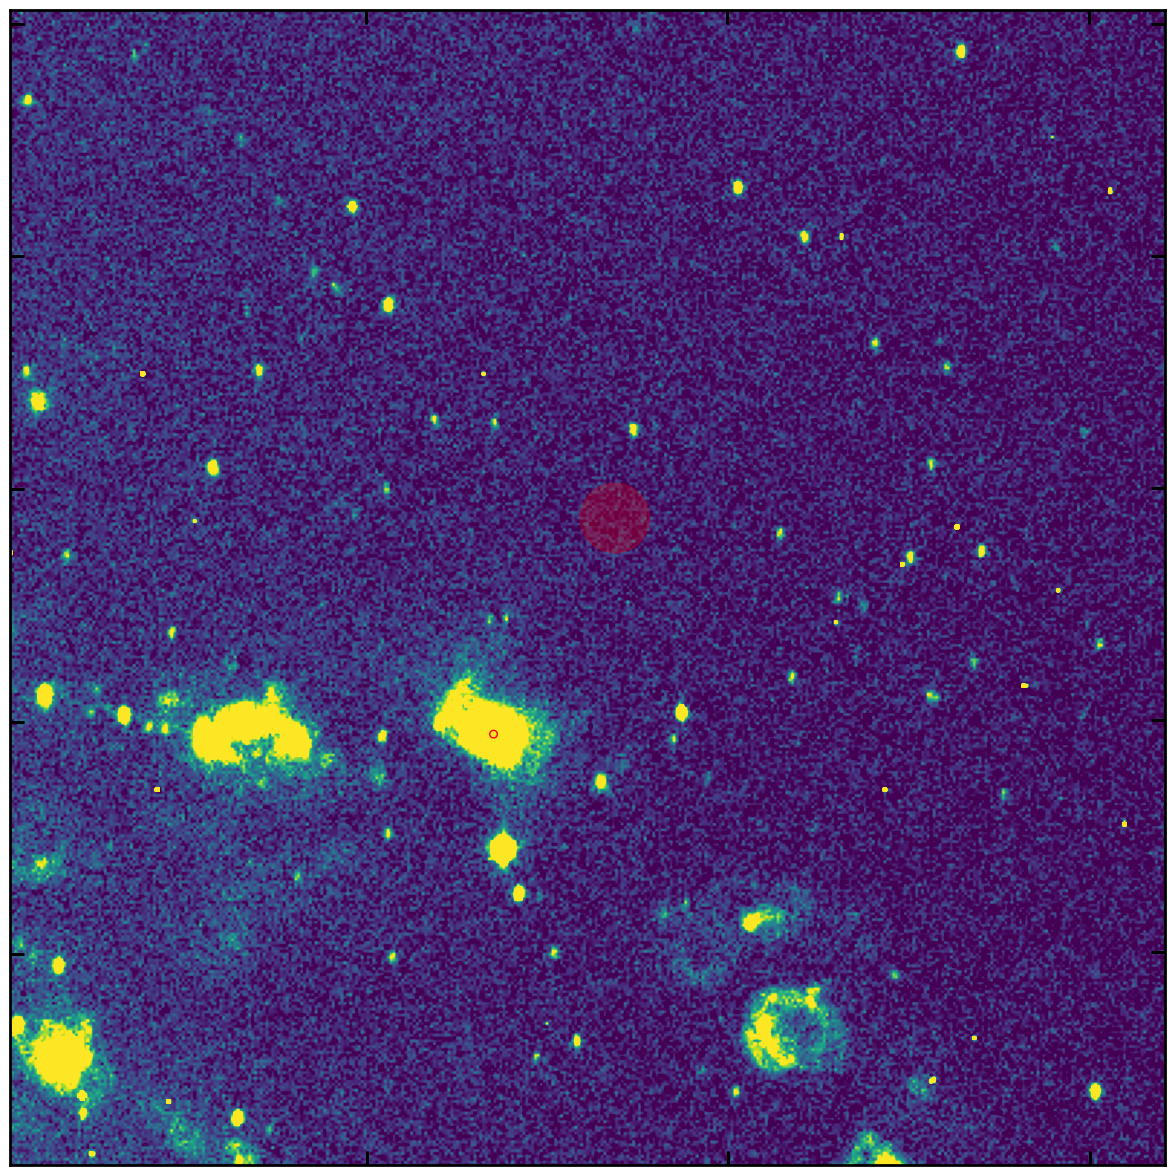

In [26]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(projection=WCS(head08nm_wcs))#, label='overlays')

percentile=[20, 99]
vmin, vmax = np.nanpercentile(im08nm_ds_ff, percentile)
print(vmin, vmax)
ax1.imshow((im08nm_ds_ff), origin='lower', vmin=vmin, vmax=vmax)

ax1.scatter(Longitude(23.316,unit=u.deg).deg,
            Latitude(30.946,unit=u.deg).deg,
            s=30, facecolors='none', edgecolors='r',
            transform=ax1.get_transform('fk5'))

y, x = np.indices((im3nm_ds_ff.shape))
x_cen,y_cen = (1909.466035, 1324.056199); r = 12
iii_x = np.where( (y-y_cen)**2 + (x-x_cen)**2 < r**2 ) 
# ax.plot(iii_x[1],iii_x[0],'r.',markersize=1,alpha=0.5)

circle1 = plt.Circle((x_cen,y_cen), r, color='r',alpha=0.25)
ax1.add_patch(circle1)

ax1.set_ylim(1100, 1500)
ax1.set_xlim(1700, 2100)

## noise calculation:
gain = 0.2363 # e-/ADU

totalflux_sky = np.sum(im08nm_ds_ff[iii_x])
print(f'0.8nm data: The total flux of sky in the patch is: {totalflux_sky:.2f} ADU or {totalflux_sky*gain:.2f} electrons')
print(f'0.8nm data: The mean sky flux in the patch is: {np.mean(im08nm_ds_ff[iii_x]):.2f} ADU or {np.mean(im08nm_ds_ff[iii_x])*gain:.2f} electrons')

# NMAD:
noise_08nm = robust.mad(im08nm_ds_ff[iii_x],c=1)*1.48
print(f'0.8nm data: The NMAD approx of sky in the patch is: {noise_08nm:.2f} ADU or {noise_08nm*gain:.2f} electrons')




In [112]:
position = SkyCoord(ra=23.316*u.deg, dec=30.946*u.deg)
position_sky = SkyCoord(ra=23.258*u.deg, dec=30.974*u.deg)
radius = 15*u.arcsec
aperture = SkyCircularAperture(position, radius)
aperture_sky = SkyCircularAperture(position_sky, radius)
# aperture.plot(color='red',lw=1.5,alpha=0.5)         

region_08nm = aperture_photometry(im08nm_ds_ff, aperture, method='exact', wcs=WCS(head08nm_wcs))
region_sky_08nm = aperture_photometry(im08nm_ds_ff, aperture_sky, method='exact', wcs=WCS(head08nm_wcs))

region_3nm = aperture_photometry(im3nm_ds_ff, aperture, method='exact', wcs=WCS(head3nm))
region_sky_3nm = aperture_photometry(im3nm_ds_ff, aperture_sky, method='exact', wcs=WCS(head3nm))


In [114]:
print(region_3nm['aperture_sum'])
print(region_sky_3nm['aperture_sum'])
region_sky_3nm

   aperture_sum  
-----------------
265472.5020440719
   aperture_sum  
-----------------
23514.60858881462


<QTable length=1>
  id       xcenter           ycenter        sky_center     aperture_sum  
             pix               pix           deg,deg                     
int64      float64           float64         SkyCoord        float64     
----- ----------------- ----------------- ------------- -----------------
    1 748.0561816147542 770.1885534627146 23.258,30.974 23514.60858881462

In [135]:
print(region_08nm['aperture_sum'])
print(region_sky_08nm['aperture_sum'])
region_sky_08nm

   aperture_sum   
------------------
249542.67006336033
   aperture_sum  
-----------------
6365.867646440259


<QTable length=1>
  id       xcenter            ycenter         sky_center     aperture_sum  
             pix                pix            deg,deg                     
int64      float64            float64          SkyCoord        float64     
----- ------------------ ------------------ ------------- -----------------
    1 1909.4660352098683 1324.0561985973898 23.258,30.974 6365.867646440259

In [160]:
## Signal-To-Noise for a small HII region:

## Need to subtract the sky value from the signal still!!!

snr_3nm = (region_3nm['aperture_sum']-region_sky_3nm['aperture_sum'])/noise_3nm
snr_08nm = (region_08nm['aperture_sum']-region_sky_08nm['aperture_sum'])/noise_08nm

print(f'SNR for 3nm data: {snr_3nm.value}')
print(f'SNR for 0.8nm data: {snr_08nm.value}')

SNR for 3nm data: [7227.20441903]
SNR for 0.8nm data: [10616.51983917]


In [161]:
snr_3nm

<Column name='aperture_sum' dtype='float64' length=1>
7227.20441902589

In [162]:
snr_08nm

<Column name='aperture_sum' dtype='float64' length=1>
10616.519839168466